**First we'll be importing all the necessary libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, ReLU
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from skimage import feature
from skimage import exposure
import seaborn as sns
import tensorflow as tf

**Reading the datasets from the directory**

In [2]:
data = pd.read_csv("/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv")
data.head(20)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
5,6,60,Male,6_left.jpg,6_right.jpg,macular epiretinal membrane,moderate non proliferative retinopathy，epireti...,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",6_right.jpg
6,7,60,Female,7_left.jpg,7_right.jpg,drusen,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",7_right.jpg
7,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",8_right.jpg
8,9,54,Male,9_left.jpg,9_right.jpg,normal fundus,vitreous degeneration,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",9_right.jpg
9,10,70,Male,10_left.jpg,10_right.jpg,epiretinal membrane,normal fundus,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",10_right.jpg


In [3]:
def has_condn(term,text):
    if term in text:
        return 1
    else:
        return 0

Attaching labels based whether cataract is present on which eye (left/right)

In [4]:
def process_dataset(data):
    data["left_cataract"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("cataract",x))
    data["right_cataract"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("cataract",x))
  
    data["LD"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("non proliferative retinopathy",x))
    data["RD"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("non proliferative retinopathy",x))

    data["LG"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma",x))
    data["RG"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma",x))
    
    data["LH"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("hypertensive",x))
    data["RH"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("hypertensive",x))

    data["LM"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("myopia",x))
    data["RM"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("myopia",x))
    
    data["LA"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("macular degeneration",x))
    data["RA"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("macular degeneration",x))
    
    data["LO"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("drusen",x))
    data["RO"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("drusen",x))
    
    left_cataract_images = data.loc[(data.C ==1) & (data.left_cataract == 1)]["Left-Fundus"].values
    right_cataract_images = data.loc[(data.C == 1) & (data.right_cataract == 1)]["Right-Fundus"].values
  
    left_normal = data.loc[(data.C == 0) & (data["Left-Diagnostic Keywords"] == "normal fundus")]['Left-Fundus'].sample(350,random_state=42).values
    right_normal = data.loc[(data.C == 0) & (data["Right-Diagnostic Keywords"] == "normal fundus")]['Right-Fundus'].sample(350,random_state=42).values
    
    left_diab = data.loc[(data.C == 0) & (data.LD == 1)]["Left-Fundus"].values
    right_diab = data.loc[(data.C == 0) & (data.RD == 1)]["Right-Fundus"].values 

    left_glaucoma = data.loc[(data.C == 0) & (data.LG == 1)]["Left-Fundus"].values
    right_glaucoma = data.loc[(data.C == 0) & (data.RG == 1)]["Right-Fundus"].values 
    
    left_hyper = data.loc[(data.C == 0) & (data.LH == 1)]["Left-Fundus"].values
    right_hyper = data.loc[(data.C == 0) & (data.RH == 1)]["Right-Fundus"].values 
    
    left_myopia = data.loc[(data.C == 0) & (data.LM == 1)]["Left-Fundus"].values
    right_myopia = data.loc[(data.C == 0) & (data.RM == 1)]["Right-Fundus"].values 
    
    left_age = data.loc[(data.C == 0) & (data.LA == 1)]["Left-Fundus"].values
    right_age = data.loc[(data.C == 0) & (data.RA == 1)]["Right-Fundus"].values 
    
    left_other = data.loc[(data.C == 0) & (data.LO == 1)]["Left-Fundus"].values
    right_other = data.loc[(data.C == 0) & (data.RO == 1)]["Right-Fundus"].values 
    
    normalones = np.concatenate((left_normal,right_normal),axis = 0);
    cataractones = np.concatenate((left_cataract_images,right_cataract_images),axis = 0);
    diabones = np.concatenate((left_diab,right_diab),axis = 0);
    glaucoma = np.concatenate((left_glaucoma,right_glaucoma),axis = 0);
    hyper = np.concatenate((left_hyper,right_hyper),axis = 0);
    myopia = np.concatenate((left_myopia,right_myopia),axis = 0);
    age = np.concatenate((left_age,right_age),axis=0);
    other = np.concatenate((left_other,right_other),axis = 0);
    
    return normalones,cataractones,diabones,glaucoma,hyper,myopia,age,other;

In [5]:
normal , cataract , diab, glaucoma , hyper , myopia , age, other = process_dataset(data);

print("Dataset stats::")
print("Normal ::" , len(normal))
print("Cataract ::" , len(cataract))
print("Diabetes ::" , len(diab))
print("Glaucoma ::" , len(glaucoma))
print("Hypertension ::" , len(hyper))
print("Myopia ::" , len(myopia))
print("Age Issues ::" , len(age))
print("Other ::" , len(other))



Dataset stats::
Normal :: 700
Cataract :: 594
Diabetes :: 1818
Glaucoma :: 610
Hypertension :: 374
Myopia :: 479
Age Issues :: 551
Other :: 324


In [6]:
reference_image: str='/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/0_right.jpg'
reference_image = cv2.imread(reference_image)
br, gr, rr = cv2.split(reference_image)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

reference_image = cv2.merge([clahe.apply(br), clahe.apply(gr), clahe.apply(rr)])

In [7]:
def preprocess_image(image_path: str, clahe: cv2.CLAHE, reference_image: np.ndarray) -> np.ndarray:
    image = cv2.imread(image_path)
    b, g, r = cv2.split(image)
    
    image = cv2.merge([clahe.apply(b), clahe.apply(g), clahe.apply(r)])
    matched_image = exposure.match_histograms(image, reference_image)
    
    matched_image = np.uint8(matched_image)

    median_filtered_image = cv2.medianBlur(matched_image, 5)
    
    bm, gm, rm = cv2.split(median_filtered_image)

    clahe_image = cv2.merge([clahe.apply(bm), clahe.apply(gm), clahe.apply(rm)])
    
    clahe_image = cv2.cvtColor(clahe_image, cv2.COLOR_BGR2RGB)
    
    return clahe_image

In [8]:
def extract_features(image: np.ndarray, block_size: tuple=(64, 64), P: int=8, R: int=1) -> np.ndarray:
    resized_image = cv2.resize(image, (224, 224))

    blocks = [resized_image[i:i+block_size[0], j:j+block_size[1]]
             for i in range(0, resized_image.shape[0], block_size[0])
             for j in range(0, resized_image.shape[1], block_size[1])]

    concatenated_features = np.array([])

    for block in blocks:
        for channel in range(3):
            channel_block = block[:, :, channel]
            ulbp_features_channel = feature.local_binary_pattern(channel_block, P, R, method='uniform')
            ulbp_features_flat_channel = ulbp_features_channel.flatten()
            concatenated_features = np.concatenate((concatenated_features, ulbp_features_flat_channel))

    return concatenated_features

In [9]:
dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images"
train_dataset = []
val_dataset = []
def dataset_generator(imagecategory , label):
    i = 0
    for img in tqdm(imagecategory):
        if (imagecategory is normal and i < 140) or (imagecategory is cataract and i < 110) or (imagecategory is diab and i < 360) or (imagecategory is glaucoma and i < 120) or (imagecategory is hyper and i < 75) or (imagecategory is myopia and i < 90) or (imagecategory is age and i < 100) or (imagecategory is other and i < 60):
            imgpath = os.path.join(dataset_dir,img);

            try:
                image = preprocess_image(imgpath, clahe, reference_image)
                image = extract_features(image)
                image = image.reshape((224, 224, 3))
            except Exception as e:
                continue;
            val_dataset.append([np.array(image), np.array(label)])
            i = i + 1
        else:
            imgpath = os.path.join(dataset_dir, img);

            try:
                image = preprocess_image(imgpath, clahe, reference_image)
                image = extract_features(image)
                image = image.reshape((224, 224, 3))
            except Exception as e:
                continue;
            train_dataset.append([np.array(image), np.array(label)])
    

Generating Dataset

In [10]:
dataset_generator(normal,0)
dataset_generator(cataract,1)
dataset_generator(diab,2)
dataset_generator(glaucoma,3)
dataset_generator(hyper,4)
dataset_generator(myopia,5)
dataset_generator(age,6)
dataset_generator(other,7)

100%|██████████| 324/324 [00:49<00:00,  6.57it/s]


In [11]:
random.shuffle(train_dataset)
random.shuffle(val_dataset)

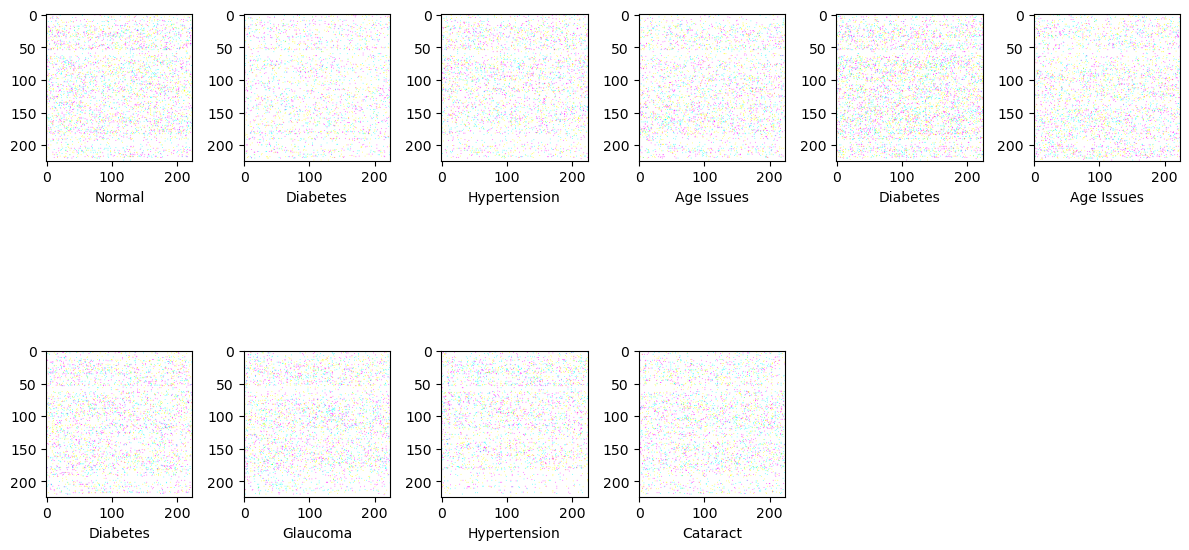

In [12]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(train_dataset)))
    image = train_dataset[sample][0]
    category = train_dataset[sample][1]
    
    if category== 0:
        label = "Normal"
    elif category == 1 :
        label = "Cataract"
    elif category == 2:
        label = "Diabetes"
    elif category == 3:
        label = "Glaucoma"
    elif category == 4:
        label = "Hypertension"
    elif category == 5:
        label = "Myopia"
    elif category == 6:
        label = "Age Issues"
    else:
        label = "Other"
           
    plt.subplot(2,6,i+1)
    plt.imshow(image, cmap='gray')
    plt.xlabel(label)
plt.tight_layout()    

In [13]:
num_classes = 8

In [14]:
x_train = np.array([i[0] for i in train_dataset])
y_train = np.array([i[1] for i in train_dataset])

x_val = np.array([i[0] for i in val_dataset])
y_val = np.array([i[1] for i in val_dataset])

y_train_cat = to_categorical(y_train, num_classes)

y_val_cat = to_categorical(y_val, num_classes)

In [15]:
x_train.shape

(4341, 224, 224, 3)

Creating the Model

In [16]:
def build_Model(input_shape=(224, 224, 3)) -> Sequential:
    model = Sequential()

    model.add(Conv2D(8, (1, 5), strides=(1, 1), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(MaxPooling2D(pool_size=(1, 2), strides=(2, 2), padding='valid'))

    model.add(Conv2D(16, (1, 5), strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(MaxPooling2D(pool_size=(1, 2), strides=(2, 2), padding='valid'))

    model.add(Conv2D(8, (1, 5), strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(MaxPooling2D(pool_size=(1, 2), strides=(2, 2), padding='valid'))

    model.add(Flatten())

    model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    return model


In [30]:
model = build_Model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 224, 224, 8)       128       
                                                                 
 batch_normalization_9 (Batc  (None, 224, 224, 8)      32        
 hNormalization)                                                 
                                                                 
 re_lu_9 (ReLU)              (None, 224, 224, 8)       0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 112, 112, 8)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 16)      656       
                                                                 
 batch_normalization_10 (Bat  (None, 112, 112, 16)    

In [31]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'categorical_accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Recall(),
    ]
)

checkpoint = ModelCheckpoint("eye_weights.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=5)

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True)

In [32]:
history = model.fit(
            x_train,y_train_cat,
            epochs=100,
            batch_size=8,
            shuffle=True,
            validation_data=(x_val, y_val_cat),
            callbacks=[checkpoint, reduceLROnPlat, early_stop]
          )

Epoch 1/100
541/543 [============================>.] - ETA: 0s - loss: 1.9795 - categorical_accuracy: 0.3045 - precision_3: 0.3166 - auc_3: 0.6750 - recall_3: 0.0189
Epoch 1: val_loss improved from inf to 1.93183, saving model to eye_weights.h5
543/543 [==============================] - 10s 13ms/step - loss: 1.9788 - categorical_accuracy: 0.3050 - precision_3: 0.3192 - auc_3: 0.6752 - recall_3: 0.0191 - val_loss: 1.9318 - val_categorical_accuracy: 0.3479 - val_precision_3: 0.5431 - val_auc_3: 0.6658 - val_recall_3: 0.0597 - lr: 0.0010
Epoch 2/100
538/543 [============================>.] - ETA: 0s - loss: 1.6835 - categorical_accuracy: 0.3820 - precision_3: 0.6602 - auc_3: 0.7734 - recall_3: 0.1115
Epoch 2: val_loss improved from 1.93183 to 1.58911, saving model to eye_weights.h5
543/543 [==============================] - 5s 9ms/step - loss: 1.6824 - categorical_accuracy: 0.3822 - precision_3: 0.6621 - auc_3: 0.7737 - recall_3: 0.1120 - val_loss: 1.5891 - val_categorical_accuracy: 0.419

In [35]:
model.load_weights('/kaggle/input/eye-weights/eye_weights.h5')

In [36]:
loss, accuracy, _, _, _ = model.evaluate(x_val, y_val_cat)
print("Accuracy: ", accuracy)
print("Loss: ", loss)

33/33 [==============================] - 0s 13ms/step - loss: 0.3979 - categorical_accuracy: 0.8863 - precision_3: 0.8990 - auc_3: 0.9847 - recall_3: 0.8777
Accuracy:  0.8862559199333191
Loss:  0.3978906571865082


33/33 [==============================] - 0s 11ms/step


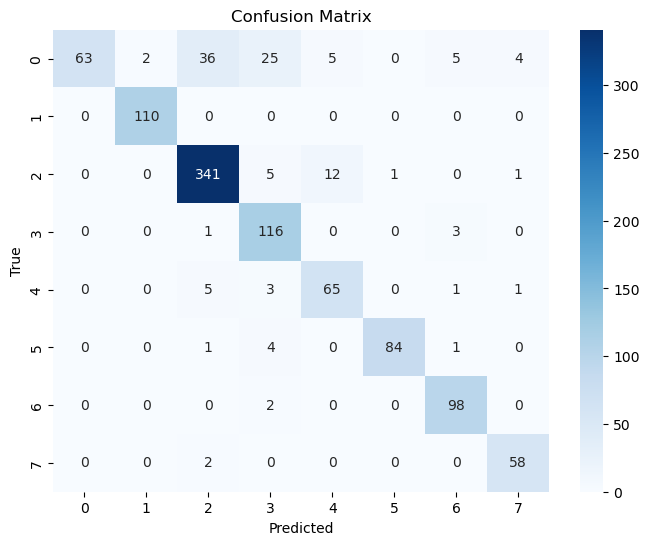

In [37]:
y_pred = model.predict(x_val)
y_pred = np.argmax(y_pred, axis=1)

y_true = np.argmax(y_val_cat, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

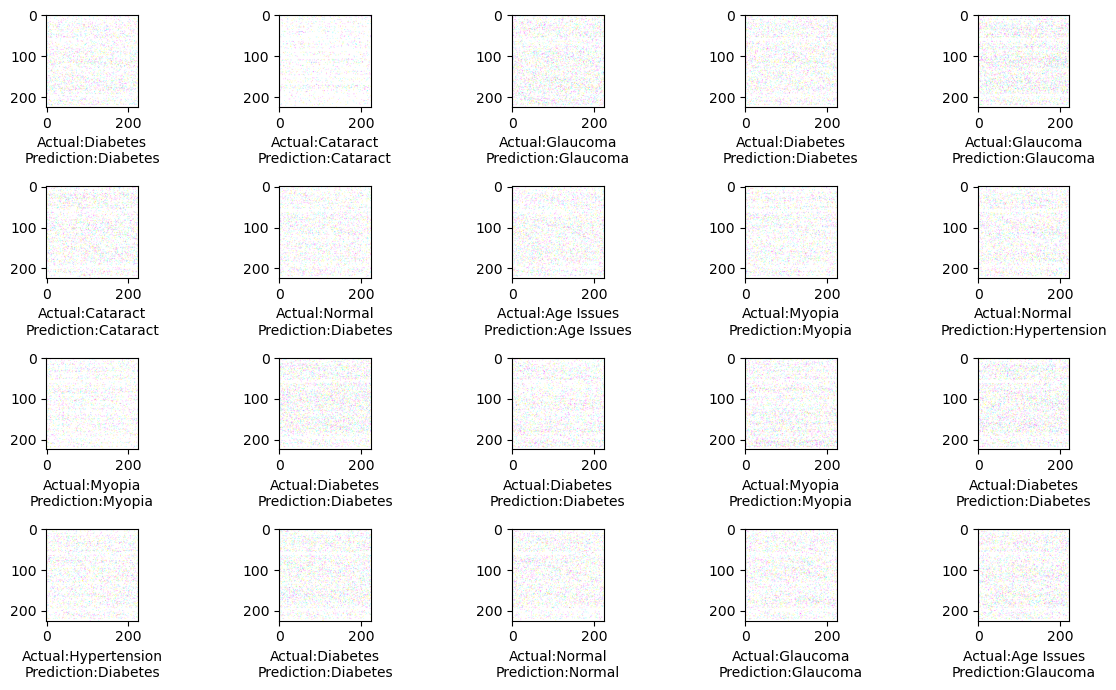

In [38]:
plt.figure(figsize=(12,7))
for i in range(20):
    sample = random.choice(range(len(x_val)))
    image = x_val[sample]
    category = y_val[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    elif category == 1 :
        label = "Cataract"
    elif category == 2:
        label = "Diabetes"
    elif category == 3:
        label = "Glaucoma"
    elif category == 4:
        label = "Hypertension"
    elif category == 5:
        label = "Myopia"
    elif category == 6:
        label = "Age Issues"
    else:
        label = "Other"
        
    if pred_category== 0:
        pred_label = "Normal"
    elif pred_category == 1 :
        pred_label = "Cataract"
    elif pred_category == 2:
        pred_label = "Diabetes"
    elif pred_category == 3:
        pred_label = "Glaucoma"
    elif pred_category == 4:
        pred_label = "Hypertension"
    elif pred_category == 5:
        pred_label = "Myopia"
    elif pred_category == 6:
        pred_label = "Age Issues"
    else:
        pred_label = "Other"
        
    plt.subplot(4,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 


In [39]:
model.save("eye_model.h5")